In [139]:
import matplotlib.pyplot as plt
import functools
import pandas as pd
import numpy as np
import requests
import scipy as sp
import quandl
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from pandas import DateOffset
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
import warnings
import statsmodels.regression.linear_model as linreg

# Suppress the warning
warnings.filterwarnings("ignore")

In [3]:
@functools.lru_cache()
def fetch_quandl_table(table, begin_date = None, end_date = None):
    qdata = quandl.get_table(table,
                      date = { 'gte': begin_date, 'lte': end_date },
                      # qopts = {"columns":["date", "adj_close"]},
                      # ticker = ticker,
                      api_key='bXgDCzJUfS5ZxasswLcN',
                      paginate=True)
    return qdata

@functools.lru_cache()
def fetch_quandl(asset, begin_date = None, end_date = None, api_key = 'bXgDCzJUfS5ZxasswLcN'):
    qdata = quandl.get(asset,
                      start_date = begin_date,
                      end_date = end_date,
                      api_key= api_key,
                      paginate=True)
    return qdata

@functools.lru_cache()
def fetch_options_price(option, date = '2014-01-01', end_date = '2022-12-31'):
    data_url = f'https://api.polygon.io/v1/open-close/{option}/{date}?adjusted=true&apiKey=cIrLrp5MiBJNGpjRm4hv7hoSbNVirkxx'
    # data_url = f'https://api.polygon.io/v3/snapshot/options/{ticker}?apiKey=cIrLrp5MiBJNGpjRm4hv7hoSbNVirkxx'
    # data_url = data_url + f'&expiration_data.gte={begin_date}'
    # data_url = data_url + f'&expiration_data.lte={end_date}'
    response = requests.get(data_url)
    if response.status_code == 200:
        return response.json()
    else:
        return response.status_code

# Get VIX close (this will be Y in our regression)

VIX_data = pd.read_csv('/Users/tmac/Downloads/VIX_History.csv')
VIX_data['DATE'] = pd.to_datetime(VIX_data['DATE'])
VIX_data = VIX_data[VIX_data['DATE'] > '2013-12-31'].set_index('DATE').drop(columns=['OPEN', 'HIGH', 'LOW']).rename(columns={'CLOSE': 'VIX'})
VIX_data = VIX_data[VIX_data.index < '2023-01-01']


# Grab (and filter) event data from FxStreet

event_data = pd.read_csv('/Users/tmac/Downloads/Economic Events.csv')
event_data['DATE'] = pd.to_datetime(event_data['Start']).dt.date
event_data = event_data.set_index('DATE')

# Set event column to True if there's an event, False otherwise

idx = pd.date_range('2014-01-01', '2022-12-31')
VIX_data = VIX_data.reindex(idx, fill_value=None)
VIX_data['Event'] = np.where(VIX_data.index.isin(event_data.index.values), True, False)
VIX_data['Days until Event'] = np.where(VIX_data['Event'] == True, 0, VIX_data.groupby((VIX_data['Event'] == True).cumsum()).cumcount(ascending=False)+1)


# TODO: do we want weekends? remove this if so, and change fill_value above to .ffill()
VIX_data = VIX_data.dropna(subset=['VIX'])

# Grab the VIX data and shift it for regression purposes

VIX_data['VIX Shifted'] = VIX_data['VIX'].shift(1)

# Consumer Sentiment (University of Michigan Consumer Survey, Index of Consumer Sentiment)
# https://data.nasdaq.com/data/UMICH/SOC1-university-of-michigan-consumer-surveyindex-of-consumer-sentiment
# NOTE: this is monthly data, so I forward filled
consumer_sentiment_data = fetch_quandl('UMICH/SOC1', begin_date='2013-12-01', end_date='2022-12-31')
VIX_data['Consumer Sentiment Index'] = consumer_sentiment_data
VIX_data['Consumer Sentiment Index'] = VIX_data['Consumer Sentiment Index'].fillna(method='ffill')
# Fill in the first month with Dec 2013 Index value
VIX_data['Consumer Sentiment Index'] = VIX_data['Consumer Sentiment Index'].fillna(value=consumer_sentiment_data.iloc[0].Index)


# Get historical 10-day volatilities
'''
SPY: Tracks S&P 500
IVW: Tracks growth stocks in S&P 500
RSP: Equally weights S&P 500
IVV: iShares S&P 500
'''
ETFS = ['VOL/SPY', 'VOL/IVW', 'VOL/RSP', 'VOL/IVV']
for ticker in ETFS:
    historical_vol = fetch_quandl('VOL/SPY', begin_date='2014-01-01', end_date='2022-12-31', api_key='iJQ34VBCfaVGdxiuTpSv')
    ticker = ticker[4:]
    VIX_data[f'{ticker} Vol'] = historical_vol['Hv10']


,VIX,Event,Days until Event,VIX Shifted,Consumer Sentiment Index,SPY Vol,IVW Vol,RSP Vol,IVV Vol
2014-01-02,14.23,False,1,NaN,82.5,0.0834,0.0834,0.0834,0.0834
2014-01-03,13.76,True,0,14.23,82.5,0.0780,0.0780,0.0780,0.0780
2014-01-06,13.55,True,0,13.76,82.5,0.0787,0.0787,0.0787,0.0787
2014-01-07,12.92,False,1,13.55,82.5,0.0820,0.0820,0.0820,0.0820
2014-01-08,12.87,True,0,12.92,82.5,0.0821,0.0821,0.0821,0.0821
...,...,...,...,...,...,...,...,...,...
2022-12-23,20.87,True,0,21.97,56.8,0.2211,0.2211,0.2211,0.2211
2022-12-27,21.65,False,5,20.87,56.8,0.1781,0.1781,0.1781,0.1781
2022-12-28,22.14,False,4,21.65,56.8,0.1668,0.1668,0.1668,0.1668
2022-12-29,21.44,False,3,22.14,56.8,0.1987,0.1987,0.1987,0.1987


In [137]:
VIX_data

,VIX,Event,Days until Event,VIX Shifted,Consumer Sentiment Index,SPY Vol,IVW Vol,RSP Vol,IVV Vol
2014-01-02,14.23,False,1,NaN,82.5,0.0834,0.0834,0.0834,0.0834
2014-01-03,13.76,True,0,14.23,82.5,0.0780,0.0780,0.0780,0.0780
2014-01-06,13.55,True,0,13.76,82.5,0.0787,0.0787,0.0787,0.0787
2014-01-07,12.92,False,1,13.55,82.5,0.0820,0.0820,0.0820,0.0820
2014-01-08,12.87,True,0,12.92,82.5,0.0821,0.0821,0.0821,0.0821
...,...,...,...,...,...,...,...,...,...
2022-12-23,20.87,True,0,21.97,56.8,0.2211,0.2211,0.2211,0.2211
2022-12-27,21.65,False,5,20.87,56.8,0.1781,0.1781,0.1781,0.1781
2022-12-28,22.14,False,4,21.65,56.8,0.1668,0.1668,0.1668,0.1668
2022-12-29,21.44,False,3,22.14,56.8,0.1987,0.1987,0.1987,0.1987


In [217]:
#model
X_train = VIX_data[:-100][['VIX','Days until Event','Consumer Sentiment Index', 'SPY Vol', 'IVW Vol', 'RSP Vol', 'IVV Vol']]
y_train = VIX_data[:-100]['VIX']
X_test = VIX_data[-100:][['VIX','Days until Event','Consumer Sentiment Index', 'SPY Vol', 'IVW Vol', 'RSP Vol', 'IVV Vol']]

In [213]:
ARIMAmodel = ARIMA(y_train, order = (7, 3, 4))
ARIMAmodel = ARIMAmodel.fit()

In [218]:
x = 100000000000
for p in tqdm(range(1,4)):
    for q in range(1,4):
        for r in range(1,4):
            ARIMAmodel = ARIMA(y_train, order = (p, q, r))
            ARIMAmodel = ARIMAmodel.fit()
            forecast = ARIMAmodel.forecast(100).to_frame()
            forecast.index = X_test.index
            diff_sq = ((X_test['VIX']-forecast['predicted_mean'])**2).sum()
            rmse = np.sqrt(diff_sq)
            if rmse < x:
                optimal = [p, q, r]
                x = rmse

100%|██████████| 3/3 [00:17<00:00,  5.75s/it]


<AxesSubplot: >

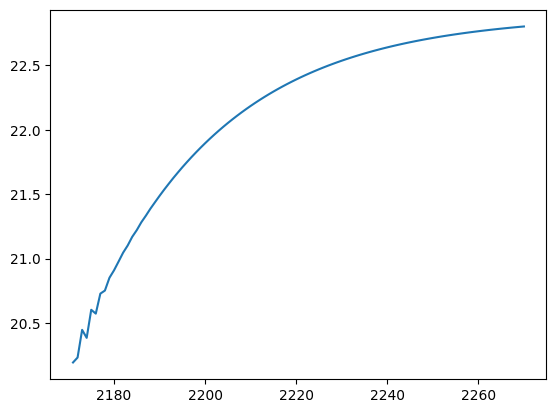

In [220]:
ARIMAmodel = ARIMA(y_train, order = (5, 1, 3))
ARIMAmodel = ARIMAmodel.fit()
ARIMAmodel.forecast(100).plot()